## LSTM 연습

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
# data = pd.read_csv('./SBUX.csv')
# print(data.dtypes)

import yfinance as yf
data = yf.download('^GSPC', start='2020-07-03', end='2024-07-04')

print(data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-07-06  3155.290039  3182.590088  3155.290039  3179.719971  3179.719971   
2020-07-07  3166.439941  3184.149902  3142.929932  3145.320068  3145.320068   
2020-07-08  3153.070068  3171.800049  3136.530029  3169.939941  3169.939941   
2020-07-09  3176.169922  3179.780029  3115.699951  3152.050049  3152.050049   
2020-07-10  3152.469971  3186.820068  3136.219971  3185.040039  3185.040039   

                Volume  
Date                    
2020-07-06  4759160000  
2020-07-07  4571330000  
2020-07-08  4937310000  
2020-07-09  4843650000  
2020-07-10  4524190000  


In [ ]:
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

날짜를 인덱스로 사용하면 시간 기반 데이터를 처리하고 분석할 때 많은 이점을 제공
- Resampling : 데이터의 빈도를 변경 ex) daily_data = data.resample('D').mean()
- 시간 기반 인덱싱 및 슬라이싱 ex) january_data = data['2024-01']  # 2024년 1월 데이터 선택
- 시계열 분석 : 시계열 분석이나 예측 모델에 필요한 다양한 시간 기반 기능을 쉽게 적용
ex) data['rolling_mean'] = data['value'].rolling(window=7).mean()  # 7일 이동 평균 계산
etc...


In [4]:
data['Volume'] = data['Volume'].astype(float)

In [9]:
# X = data.iloc[:, :-1] # 마지막 column 제외 모든 column을 x로 사용
# y = data.iloc[:, 5:6] # 마지막 Volume을 레이블로 사용
# print(X)
# print(y)

X = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']] # 'Close' 제외 모든 column을 X로 사용
y = data['Close']
print(X)
print(y)

                   Open         High          Low    Adj Close      Volume
Date                                                                      
2020-07-06  3155.290039  3182.590088  3155.290039  3179.719971  4759160000
2020-07-07  3166.439941  3184.149902  3142.929932  3145.320068  4571330000
2020-07-08  3153.070068  3171.800049  3136.530029  3169.939941  4937310000
2020-07-09  3176.169922  3179.780029  3115.699951  3152.050049  4843650000
2020-07-10  3152.469971  3186.820068  3136.219971  3185.040039  4524190000
...                 ...          ...          ...          ...         ...
2024-06-27  5473.589844  5490.810059  5467.540039  5482.870117  3589530000
2024-06-28  5488.479980  5523.640137  5451.120117  5460.479980  7199220000
2024-07-01  5471.080078  5479.549805  5446.529785  5475.089844  3488760000
2024-07-02  5461.839844  5509.689941  5458.430176  5509.009766  3329950000
2024-07-03  5507.439941  5539.270020  5507.419922  5537.020020  2179470000

[1006 rows x 5 columns]


In [11]:
ms = MinMaxScaler() # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :] # 훈련 데이터셋
X_test = X_ss[200:, :] # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

X_train shape: (200, 5)
X_test shape: (806, 5)
y shape: (1006,)


StandardScaler : 데이터의 분포를 정규 분포에 가깝게 만들며, 이상치가 있는 경우에도 어느 정도 영향을 받지만, MinMaxScaler보다는 덜 민감.
- 데이터가 정규 분포를 따르도록 하고 싶을 때 - 데이터의 분포가 넓게 퍼져있을 때
- 이상치가 어느 정도 존재하는 경우
- 분류에 유용

MinMaxScaler : 데이터의 분포가 고르게 되지 않으며, 이상치가 있는 경우 큰 영향을 받을 수 있다.
- 데이터의 최소값과 최대값이 중요한 경우 - 데이터의 범위를 제한해야 하는 경우
- 이상치가 없거나 적은 경우
- 회귀에 유용

In [7]:
X_train_tensors = Variable(torch.Tensor(X_train)) # Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# LSTM은 3차원 텐서를 입력받기 때문에 reshape/해줘야
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) # LSTM 네트워크의 입력 형태와 맞추기 위해
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [8]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes # 출력 클래스의 개수
    self.num_layers = num_layers # LSTM 층의 개수(여러 층을 쌓을수록 더 복잡한 패턴을 학습)
    self.input_size = input_size # 훈련 데이터셋의 column 개수
    self.hidden_size = hidden_size # LSTM층이 가지는 뉴런의 수
    self.seq_length = seq_length # 시퀀스의 길이

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
    self.fc = nn.Linear(128, num_classes) # 출력층
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태 0으로 초기화
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [9]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터의 feature 개수
hidden_size = 2 # 은닉층 뉴런/유닛 개수
num_layers = 1 # LSTM 계층 개수

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\user\anaconda\envs\py3_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad() # 기울기 초기화, 반복마다 새로운 기울기 계산 전 필요
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step() # 오차 업데이트
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) # loss 텐서에서 숫자 값으로 변환

Epoch: 0, loss: 0.06877
Epoch: 100, loss: 0.03932
Epoch: 200, loss: 0.03883
Epoch: 300, loss: 0.03816
Epoch: 400, loss: 0.03718
Epoch: 500, loss: 0.03596
Epoch: 600, loss: 0.03466
Epoch: 700, loss: 0.03357
Epoch: 800, loss: 0.03291
Epoch: 900, loss: 0.03264


In [11]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

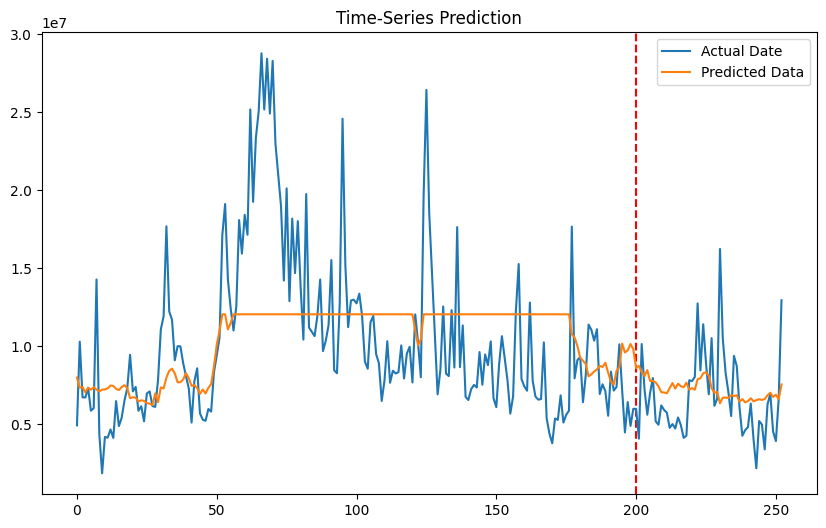

In [12]:
train_predict = model(df_x_ss) # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습 결과를 numpy로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) # 모델 학습을 위해 정규화했던 것을 해제(본래 값을 출력하기 위해)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Date')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()